In [11]:
import time
import random
import math
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon


In [2]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")

In [3]:
class Stop:

    def __init__(self, stop_id, stop_name, overlap_route_num,
                 lat, lon):
        self.stop_id = stop_id
        self.stop_name = stop_name
        self.overlap_route_num = overlap_route_num
        self.lat = lat
        self.lon = lon
        # self.wheelchair_boarding = wheelchair_boarding
        # maybe consider bike_allowed too?

class Path:

    def __init__(self, stop_sequence, stop_id, distance_traveled):
        self.stop_sequence = stop_sequence
        self.stop_id = stop_id  # stop_id: Stop
        self.distance_traveled = distance_traveled


class Route:

    def __init__(self, route_id, route_num, service_id, color, suspended):
        self.route_id = route_id
        self.route_num = route_num
        self.service_id = service_id
        self.color = color
        self.suspended = suspended  # suspended = True/False due to pandemic

        self.trip_headsign = {}  # trip_id: headsign
        self.headsign_path = {}  # headsign: Path

        # trip_id: [(arrival_time), (departure_time)]
        self.trips_wkd = {}
        self.trips_sat = {}
        self.trips_sun = {}
        self.trips_hol = {}
        self.trips_mwk = {}

    def _init_trip_headsign(self, trip_id, headsign):
        """filling data to trip_headsign"""
        self.trip_headsign[trip_id] = headsign

    def _init_headsign_path(self, headsign, Path):
        """filling data to headsign_path"""
        self.headsign_path[headsign] = Path

    def _init_trip_times(self, trip_id, service_type):
        """filling trip_ids to trip_times dictionaries"""
        service_short = service_type[3:6].lower()
        if service_short == "wkd":
            self.trips_wkd[trip_id] = []
        elif service_short == "sat":
            self.trips_sat[trip_id] = []
        elif service_short == "sun":
            self.trips_sun[trip_id] = []
        elif service_short == "hol":
            self.trips_hol[trip_id] = []
        else:
            self.trips_mwk[trip_id] = []

    def _add_trip_times(self, trip_id, service_type, arrival, departure):
        """filling arrival and departure times to trip_times dictionaries"""
        service_short = service_type[3:6].lower()
        if service_short == "wkd":
            self.trips_wkd[trip_id].extend([arrival, departure])
        elif service_short == "sat":
            self.trips_sat[trip_id].extend([arrival, departure])
        elif service_short == "sun":
            self.trips_sun[trip_id].extend([arrival, departure])
        elif service_short == "hol":
            self.trips_hol[trip_id].extend([arrival, departure])
        else:
            self.trips_mwk[trip_id].extend([arrival, departure])

class MMT:
    """
    MMT is the main class which allows us to manipulate with the data, such as plot
    generation.
    """

    def __init__(self):
        # note:
        # we look at service_id = 92 because the current trip.csv excludes suspended
        # services; service_id = 93 can be later used when we could collect more data.
        # 92 = suspended service excluded; 93 = included
        # (7 & 20 are special cases (only suspended some trips))

        # {route_num: {service_id: Route}}
        self.routes = {route_num: {} for route_num in set(routes_df["route_short_name"])}
        # {stop_id: Stop}
        self.stops = {}
        self._initialize()
        self._initialize_Stop()


    def _initialize(self):
        """initialization and extraction of the data"""
        # storing available routes and route info to Route
        for idx, row in routes_df.iterrows():
            suspended = True if "Weekday schedule trips suspended until further notice." \
                        in row["route_desc"] else False
            route_obj = Route(row["route_id"],
                              row["route_short_name"],
                              row["service_id"],
                              row["route_color"],
                              suspended)
            self.routes[row["route_short_name"]][row["service_id"]] = route_obj


        for key1, val1 in self.routes.items():
            trip_sub_df = trips_df[trips_df["route_short_name"].isin([key1])]
            for idx, row in trip_sub_df.iterrows():
                # data record time:
                # - 20200823 - 20201003 for 92, 20201004 - 20201128 for 93
                # - here we'll pick 93
                # service type included: WKD, SAT, SUN, HOL, MWK
                if row["service_id"].startswith("92"):

                    #  filling data to trip_headsign
                    self.routes[key1][92]._init_trip_headsign(row["trip_id"], row["trip_headsign"])

                    # filling trip ids to trip_times dictionaries (e.g. trips_wkd, trips_sat, etc)
                    self.routes[key1][92]._init_trip_times(row["trip_id"], row["service_id"])

                    # filling data to headsign_path
                    stop_times_sub_df = stop_times_df[stop_times_df["trip_id"].isin([row["trip_id"]])]
                    path = Path(list(stop_times_sub_df["stop_sequence"]),
                                list(stop_times_sub_df["stop_id"]),
                                list(stop_times_sub_df["shape_dist_traveled"]))
                    self.routes[key1][92]._init_headsign_path(row["trip_headsign"], path)

                    #  filling arrival and departure times to trip_times dictionaries
                    #  (e.g. trips_wkd, trips_sat, etc)
                    arrival = tuple(stop_times_sub_df["arrival_time"])
                    departure = tuple(stop_times_sub_df["departure_time"])
                    self.routes[key1][92]._add_trip_times(row["trip_id"], row["service_id"],
                                                           arrival, departure)

    def _initialize_Stop(self):
        for idx, row in stops_df.iterrows():
            if row["Route"] == "None":
                continue
            self.stops[row["stop_id"]] = Stop(row["stop_id"],
                                              row["stop_name"],
                                              list(row["Route"]),
                                              row["stop_lat"],
                                              row["stop_lon"])


    # TODO: add some functions to here

In [4]:
start = time.time()
madison = MMT()
end = time.time()

print(str(round((end - start) * 1000, 2)) + "ms")

17380.19ms


In [20]:
# generating random points
def generate_random(num_points, polygons):
    """
    take as input a numpoints and a list of polygons,
    output a list of points within the given polygons

    :param num_points: number of points generated
    :param polygons: a list of Shapely Polygon
    """
    points = []

    while len(points) < num_points:
        choice = random.choice(range(len(polygons)))
        polygon = polygons[choice]
        minx, miny, maxx, maxy = polygon.bounds
        pnt = Point(random.uniform(round(minx, 2), round(maxx, 2)),
                    random.uniform(round(miny, 2), round(maxy, 2)))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def plot_random(num_points, ax, **kwargs):
    text_offset = 0.0008
    names = []
    x = []
    y = []
    for idx, p in enumerate(generate_random(num_points, list(city.geometry))):
        names.append("p" + str(idx))
        x.append(float(p.x))
        y.append(float(p.y))
        ax.text(p.x + text_offset, p.y, "p" + str(idx), va="bottom", ha="left")
    df = pd.DataFrame({"name":names, "x":x, "y":y})

    return df.plot.scatter("x", "y", ax=ax, **kwargs)

<AxesSubplot:xlabel='x', ylabel='y'>

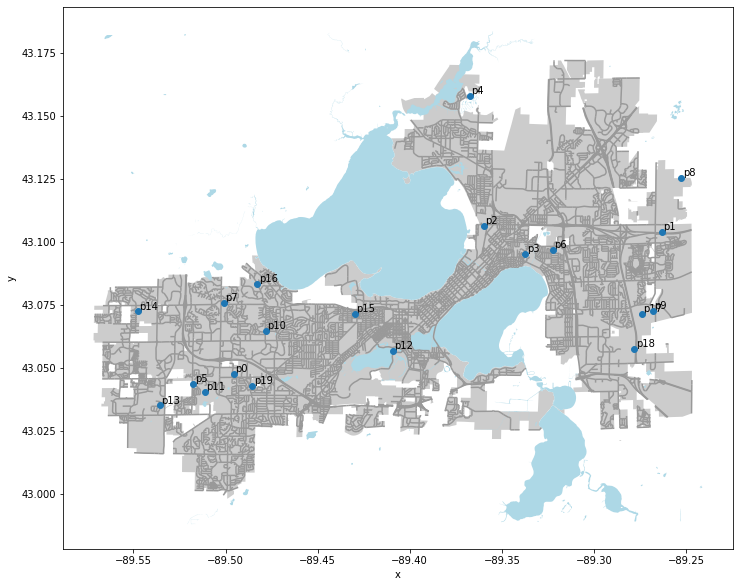

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
city.plot(color="0.8", ax=ax)
water.plot(color="lightblue", ax=ax)
street.plot(color="0.6", ax=ax)
plot_random(20, ax=ax, s=35, zorder=5)
